# Training an optimized Transformer model

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
!pwd
!p "/content/drive/My Drive/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content
/bin/bash: line 1: p: command not found


In [4]:
!pip install optuna

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 24 20:06:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             48W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [6]:
import joblib, torch, numpy as np, optuna, gc, matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from pathlib import Path

DRIVE_PROJECT = "/content/drive/My Drive/Project 3/"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running with:", DEVICE)

SUPER = joblib.load(DRIVE_PROJECT + "optimized_data_processing/super_data_payload.pkl")
train_df = SUPER["train_df"]
val_df = SUPER["val_df"]
test_df = SUPER["test_df"]
FEATURE_SETS = SUPER["feature_sets"]
ALL_NUMERIC = SUPER["numeric_cols"]

CKPT_DIR = Path(DRIVE_PROJECT + "trans_ckpts")
CKPT_DIR.mkdir(exist_ok=True)

Running with: cuda


 ## 1. Utility – caching sliding-window tensors

In [7]:
window_cache = {}


# Helper: build sliding windows
def build_windows(df, win_len, stride, feature_cols):
    data, labels = [], []
    for _, fl in df.groupby("flight_id"):
        X = fl[feature_cols].to_numpy(dtype=np.float32)
        y = fl["is_7700"].to_numpy(dtype=np.int8)  # chdanged from bool to int
        for i in range(0, len(X) - win_len + 1, stride):
            data.append(X[i : i + win_len])
            labels.append(int(y[i : i + win_len].any()))  # 1 if ANY emergency in window
    return np.stack(data), np.array(labels)


def get_windows(df, feat_key, win_len, stride):
    # Different DataFrames have different id() values
    cache_key = f"{id(df)}_{feat_key}_{win_len}_{stride}"
    if cache_key not in window_cache:
        if feat_key == "all_numeric":
            X_np, y_np = build_windows(df, win_len, stride, ALL_NUMERIC)
        else:
            X_np, y_np = build_windows(df, win_len, stride, FEATURE_SETS[feat_key])
        X_t = torch.tensor(X_np, dtype=torch.float32)
        y_t = torch.tensor(y_np, dtype=torch.float32).unsqueeze(1)
        window_cache[cache_key] = (X_t, y_t)
    return window_cache[cache_key]

 ## 2. Model definition (Transformer encoder)

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, L, d_model)

    def forward(self, x):  # x: (B,T,d)
        return x + self.pe[:, : x.size(1)]


class TransformerClassifier(nn.Module):
    def __init__(self, n_feats, d_model, n_head, n_layers, dim_ff, dropout):
        super().__init__()
        self.proj = nn.Linear(n_feats, d_model)
        self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos = PositionalEncoding(d_model, max_len=256)
        enc_layer = nn.TransformerEncoderLayer(
            d_model, n_head, dim_ff, dropout, batch_first=True
        )
        self.enc = nn.TransformerEncoder(enc_layer, n_layers)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model), nn.Dropout(dropout), nn.Linear(d_model, 1)
        )

    def forward(self, x):
        B = x.size(0)
        x = self.proj(x)  # (B, T, d_model)
        cls_token = self.cls.expand(B, -1, -1)  # (B,1,d_model)
        x = torch.cat([cls_token, x], dim=1)  # prepend
        x = self.pos(x)
        enc_out = self.enc(x)  # (B, T+1, d_model)
        cls_out = enc_out[:, 0]  # (B, d_model)
        return self.head(cls_out)

 ## 3. Objective function for Optuna

In [9]:
def objective(trial: optuna.trial.Trial):
    if DEVICE == "cuda":
        torch.cuda.empty_cache()
    # ─ data choices
    feat_key = trial.suggest_categorical(
        "features", ["all_numeric", "baseline", "transformer_xyz"]
    )
    win_len = trial.suggest_categorical("win_len", [30, 60, 120])
    stride = trial.suggest_categorical("stride", [10, 20])
    X_tr, y_tr = get_windows(train_df, feat_key, win_len, stride)
    X_va, y_va = get_windows(val_df, feat_key, win_len, stride)
    train_loader = DataLoader(
        TensorDataset(X_tr, y_tr), 256, shuffle=True, drop_last=True
    )
    val_loader = DataLoader(TensorDataset(X_va, y_va), 256, shuffle=False)

    # ─ model hyper-params
    d_model = trial.suggest_categorical("d_model", [32, 64, 128])
    n_heads = trial.suggest_categorical("n_head", [2, 4, 8])
    n_layers = trial.suggest_int("n_layers", 1, 3)
    dim_ff = trial.suggest_categorical("dim_ff", [128, 256, 512])
    drop = trial.suggest_float("drop", 0.0, 0.4, step=0.1)
    lr = trial.suggest_float("lr", 1e-4, 3e-3, log=True)

    print(
        f"Using features: {feat_key}, win_len: {win_len}, stride: {stride}"
        f", d_model: {d_model}, n_heads: {n_heads}, "
        f"n_layers: {n_layers}, dim_ff: {dim_ff}, drop: {drop}, lr: {lr}"
    )

    model = TransformerClassifier(
        X_tr.shape[2], d_model, n_heads, n_layers, dim_ff, drop
    ).to(DEVICE)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optim, mode="max", factor=0.5, patience=1
    )

    lr_curve, f1_curve = [], []
    train_loss_curve = []

    EPOCHS = 10
    for ep in range(1, EPOCHS + 1):  # 10 epochs
        print(f"Epoch {ep}/{EPOCHS}  —  LR: {optim.param_groups[0]['lr']:.6f}")
        model.train(True)
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = nn.functional.binary_cross_entropy_with_logits(logits, yb)
            optim.zero_grad()
            loss.backward()
            optim.step()
            running_loss += loss.item() * yb.size(0)
        tr_loss = running_loss / len(train_loader.dataset)
        train_loss_curve.append(tr_loss)
        # validation
        model.train(False)
        preds, gts = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                logits = model(xb.to(DEVICE))
                preds.extend((torch.sigmoid(logits) > 0.5).cpu().numpy().ravel())
                gts.extend(yb.numpy().ravel())
        val_f1 = f1_score(gts, preds)
        f1_curve.append(val_f1)
        lr_curve.append(float(optim.param_groups[0]["lr"]))

        trial.report(val_f1, ep)
        if trial.should_prune():
            print(f"Trial pruned at epoch {ep}, F1: {val_f1}")
            raise optuna.TrialPruned()
        scheduler.step(val_f1)

    # save weights
    ckpt = CKPT_DIR / f"trial_{trial.number}.pt"
    torch.save(model.state_dict(), ckpt)
    trial.set_user_attr("ckpt", str(ckpt))
    trial.set_user_attr("features", feat_key)
    trial.set_user_attr("win_len", win_len)
    trial.set_user_attr("stride", stride)
    trial.set_user_attr("lr_curve", lr_curve)
    trial.set_user_attr("val_f1_curve", f1_curve)
    trial.set_user_attr("train_loss_curve", train_loss_curve)

    del model, X_tr, y_tr, X_va, y_va, train_loader, val_loader
    torch.cuda.empty_cache()
    gc.collect()
    return f1_curve[-1]

 ## 4. Launch the study

In [10]:
TRIALS = 72
optuna.logging.set_verbosity(optuna.logging.DEBUG)
DB = f"sqlite:///{DRIVE_PROJECT}/trans_hpo.db"
study = optuna.create_study(
    study_name="trans_hpo",
    direction="maximize",
    storage=DB,
    load_if_exists=True,
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3),
)
study.optimize(objective, n_trials=TRIALS)
print("Best F1:", study.best_value)
print("Best params:", study.best_params)

[I 2025-05-24 20:06:29,222] A new study created in RDB with name: trans_hpo


Using features: baseline, win_len: 30, stride: 10, d_model: 64, n_heads: 8, n_layers: 2, dim_ff: 512, drop: 0.0, lr: 0.00011643288777039057
Epoch 1/10  —  LR: 0.000116
Epoch 2/10  —  LR: 0.000116
Epoch 3/10  —  LR: 0.000116
Epoch 4/10  —  LR: 0.000058
Epoch 5/10  —  LR: 0.000058
Epoch 6/10  —  LR: 0.000029
Epoch 7/10  —  LR: 0.000029
Epoch 8/10  —  LR: 0.000015
Epoch 9/10  —  LR: 0.000015
Epoch 10/10  —  LR: 0.000007


[I 2025-05-24 20:08:26,676] Trial 0 finished with value: 0.5770207804106109 and parameters: {'features': 'baseline', 'win_len': 30, 'stride': 10, 'd_model': 64, 'n_head': 8, 'n_layers': 2, 'dim_ff': 512, 'drop': 0.0, 'lr': 0.00011643288777039057}. Best is trial 0 with value: 0.5770207804106109.


Using features: transformer_xyz, win_len: 120, stride: 10, d_model: 64, n_heads: 4, n_layers: 3, dim_ff: 256, drop: 0.2, lr: 0.000643881479897209
Epoch 1/10  —  LR: 0.000644
Epoch 2/10  —  LR: 0.000644
Epoch 3/10  —  LR: 0.000644
Epoch 4/10  —  LR: 0.000644
Epoch 5/10  —  LR: 0.000644
Epoch 6/10  —  LR: 0.000322
Epoch 7/10  —  LR: 0.000322
Epoch 8/10  —  LR: 0.000161
Epoch 9/10  —  LR: 0.000161
Epoch 10/10  —  LR: 0.000080


[I 2025-05-24 20:11:26,934] Trial 1 finished with value: 0.6161232092791028 and parameters: {'features': 'transformer_xyz', 'win_len': 120, 'stride': 10, 'd_model': 64, 'n_head': 4, 'n_layers': 3, 'dim_ff': 256, 'drop': 0.2, 'lr': 0.000643881479897209}. Best is trial 1 with value: 0.6161232092791028.


Using features: transformer_xyz, win_len: 30, stride: 10, d_model: 128, n_heads: 4, n_layers: 1, dim_ff: 128, drop: 0.30000000000000004, lr: 0.00020388972584608995
Epoch 1/10  —  LR: 0.000204
Epoch 2/10  —  LR: 0.000204
Epoch 3/10  —  LR: 0.000204
Epoch 4/10  —  LR: 0.000102
Epoch 5/10  —  LR: 0.000102
Epoch 6/10  —  LR: 0.000051
Epoch 7/10  —  LR: 0.000051
Epoch 8/10  —  LR: 0.000025
Epoch 9/10  —  LR: 0.000025
Epoch 10/10  —  LR: 0.000013


[I 2025-05-24 20:12:53,962] Trial 2 finished with value: 0.5590924321478149 and parameters: {'features': 'transformer_xyz', 'win_len': 30, 'stride': 10, 'd_model': 128, 'n_head': 4, 'n_layers': 1, 'dim_ff': 128, 'drop': 0.30000000000000004, 'lr': 0.00020388972584608995}. Best is trial 1 with value: 0.6161232092791028.


Using features: baseline, win_len: 120, stride: 20, d_model: 128, n_heads: 2, n_layers: 3, dim_ff: 256, drop: 0.30000000000000004, lr: 0.00017473330707859033
Epoch 1/10  —  LR: 0.000175
Epoch 2/10  —  LR: 0.000175
Epoch 3/10  —  LR: 0.000175
Epoch 4/10  —  LR: 0.000175
Epoch 5/10  —  LR: 0.000175
Epoch 6/10  —  LR: 0.000087
Epoch 7/10  —  LR: 0.000087
Epoch 8/10  —  LR: 0.000087
Epoch 9/10  —  LR: 0.000044
Epoch 10/10  —  LR: 0.000044


[I 2025-05-24 20:14:53,502] Trial 3 finished with value: 0.6188219363574814 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 20, 'd_model': 128, 'n_head': 2, 'n_layers': 3, 'dim_ff': 256, 'drop': 0.30000000000000004, 'lr': 0.00017473330707859033}. Best is trial 3 with value: 0.6188219363574814.


Using features: all_numeric, win_len: 60, stride: 20, d_model: 64, n_heads: 2, n_layers: 1, dim_ff: 512, drop: 0.30000000000000004, lr: 0.002446809093878913
Epoch 1/10  —  LR: 0.002447
Epoch 2/10  —  LR: 0.002447
Epoch 3/10  —  LR: 0.002447
Epoch 4/10  —  LR: 0.002447
Epoch 5/10  —  LR: 0.002447
Epoch 6/10  —  LR: 0.002447
Epoch 7/10  —  LR: 0.001223
Epoch 8/10  —  LR: 0.001223
Epoch 9/10  —  LR: 0.000612
Epoch 10/10  —  LR: 0.000612


[I 2025-05-24 20:15:43,351] Trial 4 finished with value: 0.6137353433835846 and parameters: {'features': 'all_numeric', 'win_len': 60, 'stride': 20, 'd_model': 64, 'n_head': 2, 'n_layers': 1, 'dim_ff': 512, 'drop': 0.30000000000000004, 'lr': 0.002446809093878913}. Best is trial 3 with value: 0.6188219363574814.


Using features: baseline, win_len: 60, stride: 20, d_model: 32, n_heads: 2, n_layers: 1, dim_ff: 128, drop: 0.2, lr: 0.00010060223718264495
Epoch 1/10  —  LR: 0.000101
Epoch 2/10  —  LR: 0.000101
Epoch 3/10  —  LR: 0.000101


[I 2025-05-24 20:15:58,682] Trial 5 pruned. 


Trial pruned at epoch 3, F1: 0.5624801608295419
Using features: all_numeric, win_len: 120, stride: 10, d_model: 32, n_heads: 4, n_layers: 2, dim_ff: 512, drop: 0.30000000000000004, lr: 0.0004191970928518238
Epoch 1/10  —  LR: 0.000419
Epoch 2/10  —  LR: 0.000419
Epoch 3/10  —  LR: 0.000419
Epoch 4/10  —  LR: 0.000419
Epoch 5/10  —  LR: 0.000419
Epoch 6/10  —  LR: 0.000210
Epoch 7/10  —  LR: 0.000210
Epoch 8/10  —  LR: 0.000105
Epoch 9/10  —  LR: 0.000105
Epoch 10/10  —  LR: 0.000052


[I 2025-05-24 20:18:23,906] Trial 6 finished with value: 0.6099285501637393 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'd_model': 32, 'n_head': 4, 'n_layers': 2, 'dim_ff': 512, 'drop': 0.30000000000000004, 'lr': 0.0004191970928518238}. Best is trial 3 with value: 0.6188219363574814.


Using features: all_numeric, win_len: 120, stride: 20, d_model: 32, n_heads: 8, n_layers: 3, dim_ff: 256, drop: 0.30000000000000004, lr: 0.00011623253403614482
Epoch 1/10  —  LR: 0.000116
Epoch 2/10  —  LR: 0.000116
Epoch 3/10  —  LR: 0.000116


[I 2025-05-24 20:18:55,096] Trial 7 pruned. 


Trial pruned at epoch 3, F1: 0.6091831802803287
Using features: baseline, win_len: 60, stride: 10, d_model: 64, n_heads: 4, n_layers: 1, dim_ff: 128, drop: 0.4, lr: 0.001965852789131705
Epoch 1/10  —  LR: 0.001966
Epoch 2/10  —  LR: 0.001966
Epoch 3/10  —  LR: 0.001966


[I 2025-05-24 20:19:24,326] Trial 8 pruned. 


Trial pruned at epoch 3, F1: 0.6258813029897368
Using features: all_numeric, win_len: 120, stride: 20, d_model: 32, n_heads: 4, n_layers: 2, dim_ff: 256, drop: 0.0, lr: 0.0007965867058905149
Epoch 1/10  —  LR: 0.000797
Epoch 2/10  —  LR: 0.000797
Epoch 3/10  —  LR: 0.000797
Epoch 4/10  —  LR: 0.000797
Epoch 5/10  —  LR: 0.000398
Epoch 6/10  —  LR: 0.000398
Epoch 7/10  —  LR: 0.000199
Epoch 8/10  —  LR: 0.000199
Epoch 9/10  —  LR: 0.000100
Epoch 10/10  —  LR: 0.000100


[I 2025-05-24 20:20:28,784] Trial 9 finished with value: 0.5961116082323273 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'd_model': 32, 'n_head': 4, 'n_layers': 2, 'dim_ff': 256, 'drop': 0.0, 'lr': 0.0007965867058905149}. Best is trial 3 with value: 0.6188219363574814.


Using features: baseline, win_len: 120, stride: 20, d_model: 128, n_heads: 2, n_layers: 3, dim_ff: 256, drop: 0.1, lr: 0.00029852676980322764
Epoch 1/10  —  LR: 0.000299
Epoch 2/10  —  LR: 0.000299
Epoch 3/10  —  LR: 0.000299


[I 2025-05-24 20:21:04,821] Trial 10 pruned. 


Trial pruned at epoch 3, F1: 0.617363344051447
Using features: transformer_xyz, win_len: 120, stride: 10, d_model: 128, n_heads: 2, n_layers: 3, dim_ff: 256, drop: 0.2, lr: 0.0007544899230919011
Epoch 1/10  —  LR: 0.000754
Epoch 2/10  —  LR: 0.000754
Epoch 3/10  —  LR: 0.000754


[I 2025-05-24 20:22:14,062] Trial 11 pruned. 


Trial pruned at epoch 3, F1: 0.6166680640563428
Using features: transformer_xyz, win_len: 120, stride: 10, d_model: 128, n_heads: 4, n_layers: 3, dim_ff: 256, drop: 0.4, lr: 0.0010699145755246459
Epoch 1/10  —  LR: 0.001070
Epoch 2/10  —  LR: 0.001070
Epoch 3/10  —  LR: 0.001070


[I 2025-05-24 20:23:27,920] Trial 12 pruned. 


Trial pruned at epoch 3, F1: 0.5984434244661744
Using features: transformer_xyz, win_len: 120, stride: 20, d_model: 64, n_heads: 2, n_layers: 3, dim_ff: 256, drop: 0.1, lr: 0.00022089946040357235
Epoch 1/10  —  LR: 0.000221
Epoch 2/10  —  LR: 0.000221
Epoch 3/10  —  LR: 0.000221


[I 2025-05-24 20:23:55,360] Trial 13 pruned. 


Trial pruned at epoch 3, F1: 0.6218142933523436
Using features: baseline, win_len: 120, stride: 20, d_model: 128, n_heads: 8, n_layers: 3, dim_ff: 256, drop: 0.1, lr: 0.0004488386900716417
Epoch 1/10  —  LR: 0.000449
Epoch 2/10  —  LR: 0.000449
Epoch 3/10  —  LR: 0.000449


[I 2025-05-24 20:24:37,120] Trial 14 pruned. 


Trial pruned at epoch 3, F1: 0.5776789024842417
Using features: transformer_xyz, win_len: 30, stride: 10, d_model: 64, n_heads: 4, n_layers: 2, dim_ff: 256, drop: 0.2, lr: 0.0014611842859020624
Epoch 1/10  —  LR: 0.001461
Epoch 2/10  —  LR: 0.001461
Epoch 3/10  —  LR: 0.001461
Epoch 4/10  —  LR: 0.000731
Epoch 5/10  —  LR: 0.000731
Epoch 6/10  —  LR: 0.000365
Epoch 7/10  —  LR: 0.000365
Epoch 8/10  —  LR: 0.000183
Epoch 9/10  —  LR: 0.000183
Epoch 10/10  —  LR: 0.000091


[I 2025-05-24 20:26:39,121] Trial 15 finished with value: 0.5997893201523378 and parameters: {'features': 'transformer_xyz', 'win_len': 30, 'stride': 10, 'd_model': 64, 'n_head': 4, 'n_layers': 2, 'dim_ff': 256, 'drop': 0.2, 'lr': 0.0014611842859020624}. Best is trial 3 with value: 0.6188219363574814.


Using features: transformer_xyz, win_len: 120, stride: 10, d_model: 128, n_heads: 2, n_layers: 2, dim_ff: 256, drop: 0.2, lr: 0.0005965652231430459
Epoch 1/10  —  LR: 0.000597
Epoch 2/10  —  LR: 0.000597
Epoch 3/10  —  LR: 0.000597


[I 2025-05-24 20:27:30,689] Trial 16 pruned. 


Trial pruned at epoch 3, F1: 0.5995126584892413
Using features: baseline, win_len: 120, stride: 20, d_model: 64, n_heads: 4, n_layers: 3, dim_ff: 256, drop: 0.4, lr: 0.0002979405413076413
Epoch 1/10  —  LR: 0.000298
Epoch 2/10  —  LR: 0.000298
Epoch 3/10  —  LR: 0.000298


[I 2025-05-24 20:27:58,759] Trial 17 pruned. 


Trial pruned at epoch 3, F1: 0.5954768928220255
Using features: transformer_xyz, win_len: 30, stride: 20, d_model: 128, n_heads: 2, n_layers: 3, dim_ff: 128, drop: 0.30000000000000004, lr: 0.00017027125065697691
Epoch 1/10  —  LR: 0.000170
Epoch 2/10  —  LR: 0.000170
Epoch 3/10  —  LR: 0.000170


[I 2025-05-24 20:28:21,785] Trial 18 pruned. 


Trial pruned at epoch 3, F1: 0.568840219014435
Using features: baseline, win_len: 60, stride: 10, d_model: 64, n_heads: 8, n_layers: 3, dim_ff: 512, drop: 0.1, lr: 0.0011598064363874882
Epoch 1/10  —  LR: 0.001160
Epoch 2/10  —  LR: 0.001160
Epoch 3/10  —  LR: 0.001160
Epoch 4/10  —  LR: 0.001160
Epoch 5/10  —  LR: 0.001160
Epoch 6/10  —  LR: 0.000580
Epoch 7/10  —  LR: 0.000580
Epoch 8/10  —  LR: 0.000290
Epoch 9/10  —  LR: 0.000290
Epoch 10/10  —  LR: 0.000145


[I 2025-05-24 20:30:48,328] Trial 19 finished with value: 0.5766069051906365 and parameters: {'features': 'baseline', 'win_len': 60, 'stride': 10, 'd_model': 64, 'n_head': 8, 'n_layers': 3, 'dim_ff': 512, 'drop': 0.1, 'lr': 0.0011598064363874882}. Best is trial 3 with value: 0.6188219363574814.


Using features: transformer_xyz, win_len: 120, stride: 10, d_model: 128, n_heads: 2, n_layers: 2, dim_ff: 256, drop: 0.30000000000000004, lr: 0.0003204620893452597
Epoch 1/10  —  LR: 0.000320
Epoch 2/10  —  LR: 0.000320
Epoch 3/10  —  LR: 0.000320


[I 2025-05-24 20:31:38,628] Trial 20 pruned. 


Trial pruned at epoch 3, F1: 0.606691198240494
Using features: all_numeric, win_len: 60, stride: 20, d_model: 64, n_heads: 2, n_layers: 1, dim_ff: 512, drop: 0.30000000000000004, lr: 0.0029664124480966387
Epoch 1/10  —  LR: 0.002966
Epoch 2/10  —  LR: 0.002966
Epoch 3/10  —  LR: 0.002966


[I 2025-05-24 20:31:52,677] Trial 21 pruned. 


Trial pruned at epoch 3, F1: 0.6237936629942779
Using features: all_numeric, win_len: 60, stride: 20, d_model: 64, n_heads: 2, n_layers: 2, dim_ff: 512, drop: 0.2, lr: 0.002869503397390681
Epoch 1/10  —  LR: 0.002870
Epoch 2/10  —  LR: 0.002870
Epoch 3/10  —  LR: 0.002870


[I 2025-05-24 20:32:11,127] Trial 22 pruned. 


Trial pruned at epoch 3, F1: 0.5928462023605731
Using features: all_numeric, win_len: 60, stride: 20, d_model: 64, n_heads: 2, n_layers: 1, dim_ff: 512, drop: 0.4, lr: 0.0018331150964250626
Epoch 1/10  —  LR: 0.001833
Epoch 2/10  —  LR: 0.001833
Epoch 3/10  —  LR: 0.001833


[I 2025-05-24 20:32:25,247] Trial 23 pruned. 


Trial pruned at epoch 3, F1: 0.6060019361084221
Using features: all_numeric, win_len: 60, stride: 20, d_model: 64, n_heads: 2, n_layers: 2, dim_ff: 512, drop: 0.2, lr: 0.0006122588662858632
Epoch 1/10  —  LR: 0.000612
Epoch 2/10  —  LR: 0.000612
Epoch 3/10  —  LR: 0.000612
Epoch 4/10  —  LR: 0.000612
Epoch 5/10  —  LR: 0.000306
Epoch 6/10  —  LR: 0.000306
Epoch 7/10  —  LR: 0.000153
Epoch 8/10  —  LR: 0.000153
Epoch 9/10  —  LR: 0.000077
Epoch 10/10  —  LR: 0.000077


[I 2025-05-24 20:33:27,160] Trial 24 finished with value: 0.5881876367171677 and parameters: {'features': 'all_numeric', 'win_len': 60, 'stride': 20, 'd_model': 64, 'n_head': 2, 'n_layers': 2, 'dim_ff': 512, 'drop': 0.2, 'lr': 0.0006122588662858632}. Best is trial 3 with value: 0.6188219363574814.


Using features: all_numeric, win_len: 60, stride: 20, d_model: 64, n_heads: 4, n_layers: 3, dim_ff: 512, drop: 0.30000000000000004, lr: 0.0001562992163387152
Epoch 1/10  —  LR: 0.000156
Epoch 2/10  —  LR: 0.000156
Epoch 3/10  —  LR: 0.000156
Epoch 4/10  —  LR: 0.000156
Epoch 5/10  —  LR: 0.000156
Epoch 6/10  —  LR: 0.000078
Epoch 7/10  —  LR: 0.000078
Epoch 8/10  —  LR: 0.000039
Epoch 9/10  —  LR: 0.000039
Epoch 10/10  —  LR: 0.000039


[I 2025-05-24 20:34:43,169] Trial 25 finished with value: 0.6342686941526885 and parameters: {'features': 'all_numeric', 'win_len': 60, 'stride': 20, 'd_model': 64, 'n_head': 4, 'n_layers': 3, 'dim_ff': 512, 'drop': 0.30000000000000004, 'lr': 0.0001562992163387152}. Best is trial 25 with value: 0.6342686941526885.


Using features: baseline, win_len: 120, stride: 20, d_model: 64, n_heads: 4, n_layers: 3, dim_ff: 256, drop: 0.30000000000000004, lr: 0.00015359779850641323
Epoch 1/10  —  LR: 0.000154
Epoch 2/10  —  LR: 0.000154
Epoch 3/10  —  LR: 0.000154


[I 2025-05-24 20:35:10,354] Trial 26 pruned. 


Trial pruned at epoch 3, F1: 0.605522301602626
Using features: all_numeric, win_len: 120, stride: 20, d_model: 64, n_heads: 4, n_layers: 3, dim_ff: 128, drop: 0.4, lr: 0.00023742368410412196
Epoch 1/10  —  LR: 0.000237
Epoch 2/10  —  LR: 0.000237
Epoch 3/10  —  LR: 0.000237


[I 2025-05-24 20:35:37,077] Trial 27 pruned. 


Trial pruned at epoch 3, F1: 0.6188546255506608
Using features: baseline, win_len: 30, stride: 10, d_model: 32, n_heads: 4, n_layers: 3, dim_ff: 512, drop: 0.30000000000000004, lr: 0.0001594592869360986
Epoch 1/10  —  LR: 0.000159
Epoch 2/10  —  LR: 0.000159
Epoch 3/10  —  LR: 0.000159


[I 2025-05-24 20:36:20,145] Trial 28 pruned. 


Trial pruned at epoch 3, F1: 0.6023235839247774
Using features: transformer_xyz, win_len: 60, stride: 10, d_model: 128, n_heads: 8, n_layers: 3, dim_ff: 256, drop: 0.2, lr: 0.0004091190330323476
Epoch 1/10  —  LR: 0.000409
Epoch 2/10  —  LR: 0.000409
Epoch 3/10  —  LR: 0.000409


[I 2025-05-24 20:37:08,464] Trial 29 pruned. 


Trial pruned at epoch 3, F1: 0.6002823685740387
Using features: baseline, win_len: 30, stride: 20, d_model: 64, n_heads: 4, n_layers: 3, dim_ff: 512, drop: 0.2, lr: 0.000136375357129927
Epoch 1/10  —  LR: 0.000136
Epoch 2/10  —  LR: 0.000136
Epoch 3/10  —  LR: 0.000136


[I 2025-05-24 20:37:31,960] Trial 30 pruned. 


Trial pruned at epoch 3, F1: 0.605280466034013
Using features: all_numeric, win_len: 60, stride: 20, d_model: 64, n_heads: 2, n_layers: 2, dim_ff: 512, drop: 0.30000000000000004, lr: 0.0009094252296777898
Epoch 1/10  —  LR: 0.000909
Epoch 2/10  —  LR: 0.000909
Epoch 3/10  —  LR: 0.000909
Epoch 4/10  —  LR: 0.000909
Epoch 5/10  —  LR: 0.000455
Epoch 6/10  —  LR: 0.000455
Epoch 7/10  —  LR: 0.000227
Epoch 8/10  —  LR: 0.000227
Epoch 9/10  —  LR: 0.000114
Epoch 10/10  —  LR: 0.000114


[I 2025-05-24 20:38:33,499] Trial 31 finished with value: 0.593710292249047 and parameters: {'features': 'all_numeric', 'win_len': 60, 'stride': 20, 'd_model': 64, 'n_head': 2, 'n_layers': 2, 'dim_ff': 512, 'drop': 0.30000000000000004, 'lr': 0.0009094252296777898}. Best is trial 25 with value: 0.6342686941526885.


Using features: all_numeric, win_len: 60, stride: 20, d_model: 64, n_heads: 4, n_layers: 1, dim_ff: 512, drop: 0.30000000000000004, lr: 0.0002073406811489903
Epoch 1/10  —  LR: 0.000207
Epoch 2/10  —  LR: 0.000207
Epoch 3/10  —  LR: 0.000207
Epoch 4/10  —  LR: 0.000207
Epoch 5/10  —  LR: 0.000207
Epoch 6/10  —  LR: 0.000207
Epoch 7/10  —  LR: 0.000207
Epoch 8/10  —  LR: 0.000207
Epoch 9/10  —  LR: 0.000104
Epoch 10/10  —  LR: 0.000104


[I 2025-05-24 20:39:20,685] Trial 32 finished with value: 0.6215766099185789 and parameters: {'features': 'all_numeric', 'win_len': 60, 'stride': 20, 'd_model': 64, 'n_head': 4, 'n_layers': 1, 'dim_ff': 512, 'drop': 0.30000000000000004, 'lr': 0.0002073406811489903}. Best is trial 25 with value: 0.6342686941526885.


Using features: all_numeric, win_len: 60, stride: 20, d_model: 64, n_heads: 4, n_layers: 1, dim_ff: 512, drop: 0.30000000000000004, lr: 0.00020406600806039408
Epoch 1/10  —  LR: 0.000204
Epoch 2/10  —  LR: 0.000204
Epoch 3/10  —  LR: 0.000204


[I 2025-05-24 20:39:34,956] Trial 33 pruned. 


Trial pruned at epoch 3, F1: 0.5931061419783225
Using features: all_numeric, win_len: 60, stride: 20, d_model: 64, n_heads: 4, n_layers: 3, dim_ff: 512, drop: 0.4, lr: 0.00026303389004360097
Epoch 1/10  —  LR: 0.000263
Epoch 2/10  —  LR: 0.000263
Epoch 3/10  —  LR: 0.000263


[I 2025-05-24 20:39:57,838] Trial 34 pruned. 


Trial pruned at epoch 3, F1: 0.602173525743809
Using features: all_numeric, win_len: 60, stride: 20, d_model: 64, n_heads: 4, n_layers: 1, dim_ff: 512, drop: 0.30000000000000004, lr: 0.00012253618796286852
Epoch 1/10  —  LR: 0.000123
Epoch 2/10  —  LR: 0.000123
Epoch 3/10  —  LR: 0.000123


[I 2025-05-24 20:40:12,084] Trial 35 pruned. 


Trial pruned at epoch 3, F1: 0.5826471178951597
Using features: all_numeric, win_len: 60, stride: 20, d_model: 32, n_heads: 4, n_layers: 2, dim_ff: 128, drop: 0.0, lr: 0.00019074731609093498
Epoch 1/10  —  LR: 0.000191
Epoch 2/10  —  LR: 0.000191
Epoch 3/10  —  LR: 0.000191


[I 2025-05-24 20:40:29,859] Trial 36 pruned. 


Trial pruned at epoch 3, F1: 0.5734545091381205
Using features: transformer_xyz, win_len: 120, stride: 10, d_model: 64, n_heads: 4, n_layers: 3, dim_ff: 512, drop: 0.2, lr: 0.0003535979487125108
Epoch 1/10  —  LR: 0.000354
Epoch 2/10  —  LR: 0.000354
Epoch 3/10  —  LR: 0.000354
Epoch 4/10  —  LR: 0.000354
Epoch 5/10  —  LR: 0.000177
Epoch 6/10  —  LR: 0.000177
Epoch 7/10  —  LR: 0.000088
Epoch 8/10  —  LR: 0.000088
Epoch 9/10  —  LR: 0.000044
Epoch 10/10  —  LR: 0.000044


[I 2025-05-24 20:43:56,072] Trial 37 finished with value: 0.6075110456553755 and parameters: {'features': 'transformer_xyz', 'win_len': 120, 'stride': 10, 'd_model': 64, 'n_head': 4, 'n_layers': 3, 'dim_ff': 512, 'drop': 0.2, 'lr': 0.0003535979487125108}. Best is trial 25 with value: 0.6342686941526885.


Using features: baseline, win_len: 30, stride: 20, d_model: 128, n_heads: 4, n_layers: 1, dim_ff: 256, drop: 0.30000000000000004, lr: 0.0001095883327463124
Epoch 1/10  —  LR: 0.000110
Epoch 2/10  —  LR: 0.000110
Epoch 3/10  —  LR: 0.000110


[I 2025-05-24 20:44:09,286] Trial 38 pruned. 


Trial pruned at epoch 3, F1: 0.566483404601914
Using features: all_numeric, win_len: 60, stride: 10, d_model: 32, n_heads: 8, n_layers: 2, dim_ff: 128, drop: 0.30000000000000004, lr: 0.0001405597185308258
Epoch 1/10  —  LR: 0.000141
Epoch 2/10  —  LR: 0.000141
Epoch 3/10  —  LR: 0.000141


[I 2025-05-24 20:44:49,277] Trial 39 pruned. 


Trial pruned at epoch 3, F1: 0.5879741337708715
Using features: all_numeric, win_len: 120, stride: 20, d_model: 64, n_heads: 4, n_layers: 3, dim_ff: 512, drop: 0.1, lr: 0.00047422399734321183
Epoch 1/10  —  LR: 0.000474
Epoch 2/10  —  LR: 0.000474
Epoch 3/10  —  LR: 0.000474
Epoch 4/10  —  LR: 0.000474
Epoch 5/10  —  LR: 0.000474
Epoch 6/10  —  LR: 0.000237
Epoch 7/10  —  LR: 0.000237
Epoch 8/10  —  LR: 0.000119
Epoch 9/10  —  LR: 0.000119
Epoch 10/10  —  LR: 0.000059


[I 2025-05-24 20:46:38,670] Trial 40 finished with value: 0.5900451030927835 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'd_model': 64, 'n_head': 4, 'n_layers': 3, 'dim_ff': 512, 'drop': 0.1, 'lr': 0.00047422399734321183}. Best is trial 25 with value: 0.6342686941526885.


Using features: all_numeric, win_len: 60, stride: 20, d_model: 64, n_heads: 2, n_layers: 1, dim_ff: 512, drop: 0.30000000000000004, lr: 0.00018630505745951352
Epoch 1/10  —  LR: 0.000186
Epoch 2/10  —  LR: 0.000186
Epoch 3/10  —  LR: 0.000186


[I 2025-05-24 20:46:52,945] Trial 41 pruned. 


Trial pruned at epoch 3, F1: 0.620157919182536
Using features: all_numeric, win_len: 60, stride: 20, d_model: 64, n_heads: 4, n_layers: 1, dim_ff: 512, drop: 0.4, lr: 0.001963495526454442
Epoch 1/10  —  LR: 0.001963
Epoch 2/10  —  LR: 0.001963
Epoch 3/10  —  LR: 0.001963


[I 2025-05-24 20:47:07,168] Trial 42 pruned. 


Trial pruned at epoch 3, F1: 0.5514075887392901
Using features: all_numeric, win_len: 60, stride: 20, d_model: 64, n_heads: 2, n_layers: 1, dim_ff: 512, drop: 0.30000000000000004, lr: 0.0002494375415103861
Epoch 1/10  —  LR: 0.000249
Epoch 2/10  —  LR: 0.000249
Epoch 3/10  —  LR: 0.000249


[I 2025-05-24 20:47:21,409] Trial 43 pruned. 


Trial pruned at epoch 3, F1: 0.5966508566450489
Using features: baseline, win_len: 120, stride: 20, d_model: 128, n_heads: 4, n_layers: 1, dim_ff: 256, drop: 0.2, lr: 0.0007130203451049322
Epoch 1/10  —  LR: 0.000713
Epoch 2/10  —  LR: 0.000713
Epoch 3/10  —  LR: 0.000713
Epoch 4/10  —  LR: 0.000357
Epoch 5/10  —  LR: 0.000357
Epoch 6/10  —  LR: 0.000357
Epoch 7/10  —  LR: 0.000178
Epoch 8/10  —  LR: 0.000178
Epoch 9/10  —  LR: 0.000178
Epoch 10/10  —  LR: 0.000178


[I 2025-05-24 20:48:20,042] Trial 44 finished with value: 0.6355048057175717 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 20, 'd_model': 128, 'n_head': 4, 'n_layers': 1, 'dim_ff': 256, 'drop': 0.2, 'lr': 0.0007130203451049322}. Best is trial 44 with value: 0.6355048057175717.


Using features: baseline, win_len: 120, stride: 20, d_model: 128, n_heads: 4, n_layers: 1, dim_ff: 256, drop: 0.2, lr: 0.0007194619699662771
Epoch 1/10  —  LR: 0.000719
Epoch 2/10  —  LR: 0.000719
Epoch 3/10  —  LR: 0.000719
Epoch 4/10  —  LR: 0.000719
Epoch 5/10  —  LR: 0.000719
Epoch 6/10  —  LR: 0.000360
Epoch 7/10  —  LR: 0.000360
Epoch 8/10  —  LR: 0.000360
Epoch 9/10  —  LR: 0.000360
Epoch 10/10  —  LR: 0.000360


[I 2025-05-24 20:49:18,456] Trial 45 finished with value: 0.610964216463952 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 20, 'd_model': 128, 'n_head': 4, 'n_layers': 1, 'dim_ff': 256, 'drop': 0.2, 'lr': 0.0007194619699662771}. Best is trial 44 with value: 0.6355048057175717.


Using features: baseline, win_len: 120, stride: 20, d_model: 128, n_heads: 4, n_layers: 3, dim_ff: 256, drop: 0.2, lr: 0.000534337904677254
Epoch 1/10  —  LR: 0.000534
Epoch 2/10  —  LR: 0.000534
Epoch 3/10  —  LR: 0.000534


[I 2025-05-24 20:49:55,280] Trial 46 pruned. 


Trial pruned at epoch 3, F1: 0.5867851752473587
Using features: baseline, win_len: 120, stride: 10, d_model: 128, n_heads: 4, n_layers: 1, dim_ff: 256, drop: 0.2, lr: 0.0008836897022392538
Epoch 1/10  —  LR: 0.000884
Epoch 2/10  —  LR: 0.000884
Epoch 3/10  —  LR: 0.000884
Epoch 4/10  —  LR: 0.000884
Epoch 5/10  —  LR: 0.000884
Epoch 6/10  —  LR: 0.000442
Epoch 7/10  —  LR: 0.000442
Epoch 8/10  —  LR: 0.000442
Epoch 9/10  —  LR: 0.000442
Epoch 10/10  —  LR: 0.000442


[I 2025-05-24 20:51:54,705] Trial 47 finished with value: 0.5975695667488552 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 10, 'd_model': 128, 'n_head': 4, 'n_layers': 1, 'dim_ff': 256, 'drop': 0.2, 'lr': 0.0008836897022392538}. Best is trial 44 with value: 0.6355048057175717.


Using features: baseline, win_len: 120, stride: 20, d_model: 128, n_heads: 4, n_layers: 2, dim_ff: 256, drop: 0.2, lr: 0.00037646583653790685
Epoch 1/10  —  LR: 0.000376
Epoch 2/10  —  LR: 0.000376
Epoch 3/10  —  LR: 0.000376


[I 2025-05-24 20:52:22,028] Trial 48 pruned. 


Trial pruned at epoch 3, F1: 0.6032603957806643
Using features: transformer_xyz, win_len: 120, stride: 10, d_model: 128, n_heads: 8, n_layers: 3, dim_ff: 256, drop: 0.1, lr: 0.0006608375050458076
Epoch 1/10  —  LR: 0.000661
Epoch 2/10  —  LR: 0.000661
Epoch 3/10  —  LR: 0.000661


[I 2025-05-24 20:53:42,094] Trial 49 pruned. 


Trial pruned at epoch 3, F1: 0.6096339113680154
Using features: baseline, win_len: 120, stride: 20, d_model: 128, n_heads: 4, n_layers: 3, dim_ff: 256, drop: 0.30000000000000004, lr: 0.0012076072131634642
Epoch 1/10  —  LR: 0.001208
Epoch 2/10  —  LR: 0.001208
Epoch 3/10  —  LR: 0.001208
Epoch 4/10  —  LR: 0.001208
Epoch 5/10  —  LR: 0.000604
Epoch 6/10  —  LR: 0.000604
Epoch 7/10  —  LR: 0.000302
Epoch 8/10  —  LR: 0.000302
Epoch 9/10  —  LR: 0.000151
Epoch 10/10  —  LR: 0.000151


[I 2025-05-24 20:55:45,678] Trial 50 finished with value: 0.5941401698018978 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 20, 'd_model': 128, 'n_head': 4, 'n_layers': 3, 'dim_ff': 256, 'drop': 0.30000000000000004, 'lr': 0.0012076072131634642}. Best is trial 44 with value: 0.6355048057175717.


Using features: transformer_xyz, win_len: 60, stride: 20, d_model: 32, n_heads: 2, n_layers: 1, dim_ff: 256, drop: 0.30000000000000004, lr: 0.0023187590401960896
Epoch 1/10  —  LR: 0.002319
Epoch 2/10  —  LR: 0.002319
Epoch 3/10  —  LR: 0.002319
Epoch 4/10  —  LR: 0.002319
Epoch 5/10  —  LR: 0.002319
Epoch 6/10  —  LR: 0.001159
Epoch 7/10  —  LR: 0.001159
Epoch 8/10  —  LR: 0.000580
Epoch 9/10  —  LR: 0.000580
Epoch 10/10  —  LR: 0.000290


[I 2025-05-24 20:56:31,062] Trial 51 finished with value: 0.5927982967694159 and parameters: {'features': 'transformer_xyz', 'win_len': 60, 'stride': 20, 'd_model': 32, 'n_head': 2, 'n_layers': 1, 'dim_ff': 256, 'drop': 0.30000000000000004, 'lr': 0.0023187590401960896}. Best is trial 44 with value: 0.6355048057175717.


Using features: all_numeric, win_len: 120, stride: 20, d_model: 64, n_heads: 2, n_layers: 1, dim_ff: 256, drop: 0.2, lr: 0.0013892464749192398
Epoch 1/10  —  LR: 0.001389
Epoch 2/10  —  LR: 0.001389
Epoch 3/10  —  LR: 0.001389


[I 2025-05-24 20:56:46,932] Trial 52 pruned. 


Trial pruned at epoch 3, F1: 0.6132731376975169
Using features: baseline, win_len: 60, stride: 20, d_model: 64, n_heads: 4, n_layers: 1, dim_ff: 512, drop: 0.30000000000000004, lr: 0.0002830985962288764
Epoch 1/10  —  LR: 0.000283
Epoch 2/10  —  LR: 0.000283
Epoch 3/10  —  LR: 0.000283


[I 2025-05-24 20:57:00,484] Trial 53 pruned. 


Trial pruned at epoch 3, F1: 0.5523219814241486
Using features: transformer_xyz, win_len: 120, stride: 20, d_model: 128, n_heads: 2, n_layers: 1, dim_ff: 128, drop: 0.4, lr: 0.0005025076579775987
Epoch 1/10  —  LR: 0.000503
Epoch 2/10  —  LR: 0.000503
Epoch 3/10  —  LR: 0.000503


[I 2025-05-24 20:57:16,301] Trial 54 pruned. 


Trial pruned at epoch 3, F1: 0.5707986772221666
Using features: all_numeric, win_len: 30, stride: 10, d_model: 64, n_heads: 4, n_layers: 1, dim_ff: 256, drop: 0.30000000000000004, lr: 0.0016588402470635961
Epoch 1/10  —  LR: 0.001659
Epoch 2/10  —  LR: 0.001659
Epoch 3/10  —  LR: 0.001659
Epoch 4/10  —  LR: 0.001659
Epoch 5/10  —  LR: 0.000829
Epoch 6/10  —  LR: 0.000829
Epoch 7/10  —  LR: 0.000415
Epoch 8/10  —  LR: 0.000415
Epoch 9/10  —  LR: 0.000207
Epoch 10/10  —  LR: 0.000207


[I 2025-05-24 20:58:51,016] Trial 55 finished with value: 0.6139538833920761 and parameters: {'features': 'all_numeric', 'win_len': 30, 'stride': 10, 'd_model': 64, 'n_head': 4, 'n_layers': 1, 'dim_ff': 256, 'drop': 0.30000000000000004, 'lr': 0.0016588402470635961}. Best is trial 44 with value: 0.6355048057175717.


Using features: all_numeric, win_len: 30, stride: 10, d_model: 64, n_heads: 4, n_layers: 1, dim_ff: 256, drop: 0.2, lr: 0.00010257987008131183
Epoch 1/10  —  LR: 0.000103
Epoch 2/10  —  LR: 0.000103
Epoch 3/10  —  LR: 0.000103


[I 2025-05-24 20:59:18,457] Trial 56 pruned. 


Trial pruned at epoch 3, F1: 0.59156585198609
Using features: baseline, win_len: 30, stride: 10, d_model: 64, n_heads: 4, n_layers: 3, dim_ff: 256, drop: 0.30000000000000004, lr: 0.001564179787599698
Epoch 1/10  —  LR: 0.001564
Epoch 2/10  —  LR: 0.001564
Epoch 3/10  —  LR: 0.001564


[I 2025-05-24 21:00:04,934] Trial 57 pruned. 


Trial pruned at epoch 3, F1: 0.5728199791883455
Using features: all_numeric, win_len: 30, stride: 10, d_model: 128, n_heads: 4, n_layers: 1, dim_ff: 256, drop: 0.30000000000000004, lr: 0.0009201302078848026
Epoch 1/10  —  LR: 0.000920
Epoch 2/10  —  LR: 0.000920
Epoch 3/10  —  LR: 0.000920
Epoch 4/10  —  LR: 0.000920
Epoch 5/10  —  LR: 0.000460
Epoch 6/10  —  LR: 0.000460
Epoch 7/10  —  LR: 0.000230
Epoch 8/10  —  LR: 0.000230
Epoch 9/10  —  LR: 0.000115
Epoch 10/10  —  LR: 0.000115


[I 2025-05-24 21:01:36,141] Trial 58 finished with value: 0.5853427488804684 and parameters: {'features': 'all_numeric', 'win_len': 30, 'stride': 10, 'd_model': 128, 'n_head': 4, 'n_layers': 1, 'dim_ff': 256, 'drop': 0.30000000000000004, 'lr': 0.0009201302078848026}. Best is trial 44 with value: 0.6355048057175717.


Using features: transformer_xyz, win_len: 30, stride: 10, d_model: 64, n_heads: 4, n_layers: 3, dim_ff: 256, drop: 0.1, lr: 0.00013368625451848915
Epoch 1/10  —  LR: 0.000134
Epoch 2/10  —  LR: 0.000134
Epoch 3/10  —  LR: 0.000134


[I 2025-05-24 21:02:21,679] Trial 59 pruned. 


Trial pruned at epoch 3, F1: 0.559841740850643
Using features: baseline, win_len: 30, stride: 10, d_model: 128, n_heads: 4, n_layers: 2, dim_ff: 256, drop: 0.2, lr: 0.00016930904586419932
Epoch 1/10  —  LR: 0.000169
Epoch 2/10  —  LR: 0.000169
Epoch 3/10  —  LR: 0.000169
Epoch 4/10  —  LR: 0.000169
Epoch 5/10  —  LR: 0.000085
Epoch 6/10  —  LR: 0.000085
Epoch 7/10  —  LR: 0.000042
Epoch 8/10  —  LR: 0.000042
Epoch 9/10  —  LR: 0.000021
Epoch 10/10  —  LR: 0.000021


[I 2025-05-24 21:04:19,582] Trial 60 finished with value: 0.5890042609523022 and parameters: {'features': 'baseline', 'win_len': 30, 'stride': 10, 'd_model': 128, 'n_head': 4, 'n_layers': 2, 'dim_ff': 256, 'drop': 0.2, 'lr': 0.00016930904586419932}. Best is trial 44 with value: 0.6355048057175717.


Using features: all_numeric, win_len: 120, stride: 20, d_model: 64, n_heads: 2, n_layers: 1, dim_ff: 512, drop: 0.30000000000000004, lr: 0.0024766473324110906
Epoch 1/10  —  LR: 0.002477
Epoch 2/10  —  LR: 0.002477
Epoch 3/10  —  LR: 0.002477
Epoch 4/10  —  LR: 0.001238
Epoch 5/10  —  LR: 0.001238
Epoch 6/10  —  LR: 0.000619
Epoch 7/10  —  LR: 0.000619
Epoch 8/10  —  LR: 0.000310
Epoch 9/10  —  LR: 0.000310
Epoch 10/10  —  LR: 0.000155


[I 2025-05-24 21:05:15,273] Trial 61 finished with value: 0.5928982890551113 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'd_model': 64, 'n_head': 2, 'n_layers': 1, 'dim_ff': 512, 'drop': 0.30000000000000004, 'lr': 0.0024766473324110906}. Best is trial 44 with value: 0.6355048057175717.


Using features: all_numeric, win_len: 60, stride: 10, d_model: 64, n_heads: 8, n_layers: 1, dim_ff: 256, drop: 0.30000000000000004, lr: 0.0024644702549501615
Epoch 1/10  —  LR: 0.002464
Epoch 2/10  —  LR: 0.002464
Epoch 3/10  —  LR: 0.002464


[I 2025-05-24 21:05:43,723] Trial 62 pruned. 


Trial pruned at epoch 3, F1: 0.5962066281594364
Using features: all_numeric, win_len: 120, stride: 20, d_model: 64, n_heads: 2, n_layers: 1, dim_ff: 512, drop: 0.4, lr: 0.0010444430778814844
Epoch 1/10  —  LR: 0.001044
Epoch 2/10  —  LR: 0.001044
Epoch 3/10  —  LR: 0.001044
Epoch 4/10  —  LR: 0.001044
Epoch 5/10  —  LR: 0.001044
Epoch 6/10  —  LR: 0.001044
Epoch 7/10  —  LR: 0.000522
Epoch 8/10  —  LR: 0.000522
Epoch 9/10  —  LR: 0.000261
Epoch 10/10  —  LR: 0.000261


[I 2025-05-24 21:06:39,257] Trial 63 finished with value: 0.6172839506172839 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'd_model': 64, 'n_head': 2, 'n_layers': 1, 'dim_ff': 512, 'drop': 0.4, 'lr': 0.0010444430778814844}. Best is trial 44 with value: 0.6355048057175717.


Using features: all_numeric, win_len: 120, stride: 20, d_model: 64, n_heads: 4, n_layers: 1, dim_ff: 512, drop: 0.4, lr: 0.0011186874893961104
Epoch 1/10  —  LR: 0.001119
Epoch 2/10  —  LR: 0.001119
Epoch 3/10  —  LR: 0.001119


[I 2025-05-24 21:06:56,566] Trial 64 pruned. 


Trial pruned at epoch 3, F1: 0.6040643359337379
Using features: all_numeric, win_len: 120, stride: 20, d_model: 64, n_heads: 2, n_layers: 1, dim_ff: 256, drop: 0.4, lr: 0.0009988016235991934
Epoch 1/10  —  LR: 0.000999
Epoch 2/10  —  LR: 0.000999
Epoch 3/10  —  LR: 0.000999
Epoch 4/10  —  LR: 0.000999
Epoch 5/10  —  LR: 0.000499
Epoch 6/10  —  LR: 0.000499
Epoch 7/10  —  LR: 0.000250
Epoch 8/10  —  LR: 0.000250
Epoch 9/10  —  LR: 0.000125
Epoch 10/10  —  LR: 0.000125


[I 2025-05-24 21:07:49,322] Trial 65 finished with value: 0.6146245059288538 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'd_model': 64, 'n_head': 2, 'n_layers': 1, 'dim_ff': 256, 'drop': 0.4, 'lr': 0.0009988016235991934}. Best is trial 44 with value: 0.6355048057175717.


Using features: all_numeric, win_len: 120, stride: 20, d_model: 64, n_heads: 2, n_layers: 1, dim_ff: 512, drop: 0.4, lr: 0.001010341550068592
Epoch 1/10  —  LR: 0.001010
Epoch 2/10  —  LR: 0.001010
Epoch 3/10  —  LR: 0.001010
Epoch 4/10  —  LR: 0.001010
Epoch 5/10  —  LR: 0.000505
Epoch 6/10  —  LR: 0.000505
Epoch 7/10  —  LR: 0.000253
Epoch 8/10  —  LR: 0.000253
Epoch 9/10  —  LR: 0.000126
Epoch 10/10  —  LR: 0.000126


[I 2025-05-24 21:08:45,314] Trial 66 finished with value: 0.6239316239316239 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'd_model': 64, 'n_head': 2, 'n_layers': 1, 'dim_ff': 512, 'drop': 0.4, 'lr': 0.001010341550068592}. Best is trial 44 with value: 0.6355048057175717.


Using features: transformer_xyz, win_len: 120, stride: 20, d_model: 32, n_heads: 2, n_layers: 3, dim_ff: 512, drop: 0.4, lr: 0.0007753078437474974
Epoch 1/10  —  LR: 0.000775
Epoch 2/10  —  LR: 0.000775
Epoch 3/10  —  LR: 0.000775


[I 2025-05-24 21:09:08,837] Trial 67 pruned. 


Trial pruned at epoch 3, F1: 0.6170082860880942
Using features: all_numeric, win_len: 120, stride: 20, d_model: 64, n_heads: 2, n_layers: 1, dim_ff: 512, drop: 0.4, lr: 0.000585571425366208
Epoch 1/10  —  LR: 0.000586
Epoch 2/10  —  LR: 0.000586
Epoch 3/10  —  LR: 0.000586


[I 2025-05-24 21:09:25,516] Trial 68 pruned. 


Trial pruned at epoch 3, F1: 0.6153144108788902
Using features: baseline, win_len: 120, stride: 20, d_model: 64, n_heads: 2, n_layers: 2, dim_ff: 512, drop: 0.4, lr: 0.0012691588429277231
Epoch 1/10  —  LR: 0.001269
Epoch 2/10  —  LR: 0.001269
Epoch 3/10  —  LR: 0.001269
Epoch 4/10  —  LR: 0.001269
Epoch 5/10  —  LR: 0.000635
Epoch 6/10  —  LR: 0.000635
Epoch 7/10  —  LR: 0.000317
Epoch 8/10  —  LR: 0.000317
Epoch 9/10  —  LR: 0.000159
Epoch 10/10  —  LR: 0.000159


[I 2025-05-24 21:10:39,851] Trial 69 finished with value: 0.6082474226804123 and parameters: {'features': 'baseline', 'win_len': 120, 'stride': 20, 'd_model': 64, 'n_head': 2, 'n_layers': 2, 'dim_ff': 512, 'drop': 0.4, 'lr': 0.0012691588429277231}. Best is trial 44 with value: 0.6355048057175717.


Using features: all_numeric, win_len: 120, stride: 20, d_model: 128, n_heads: 2, n_layers: 3, dim_ff: 512, drop: 0.4, lr: 0.0006915297800389508
Epoch 1/10  —  LR: 0.000692
Epoch 2/10  —  LR: 0.000692
Epoch 3/10  —  LR: 0.000692


[I 2025-05-24 21:11:22,156] Trial 70 pruned. 


Trial pruned at epoch 3, F1: 0.5701614927621119
Using features: all_numeric, win_len: 120, stride: 20, d_model: 64, n_heads: 2, n_layers: 1, dim_ff: 512, drop: 0.4, lr: 0.0010160222711577934
Epoch 1/10  —  LR: 0.001016
Epoch 2/10  —  LR: 0.001016
Epoch 3/10  —  LR: 0.001016
Epoch 4/10  —  LR: 0.001016
Epoch 5/10  —  LR: 0.001016
Epoch 6/10  —  LR: 0.000508
Epoch 7/10  —  LR: 0.000508
Epoch 8/10  —  LR: 0.000254
Epoch 9/10  —  LR: 0.000254
Epoch 10/10  —  LR: 0.000254


[I 2025-05-24 21:12:17,754] Trial 71 finished with value: 0.6452769007594504 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'd_model': 64, 'n_head': 2, 'n_layers': 1, 'dim_ff': 512, 'drop': 0.4, 'lr': 0.0010160222711577934}. Best is trial 71 with value: 0.6452769007594504.


Best F1: 0.6452769007594504
Best params: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'd_model': 64, 'n_head': 2, 'n_layers': 1, 'dim_ff': 512, 'drop': 0.4, 'lr': 0.0010160222711577934}


 ## 5. Reload best model & evaluate on **test** split

In [11]:
best = study.best_trial
cols = (
    ALL_NUMERIC
    if best.user_attrs["features"] == "all_numeric"
    else FEATURE_SETS[best.user_attrs["features"]]
)
WIN, STR = best.user_attrs["win_len"], best.user_attrs["stride"]
X_te, y_te = build_windows(test_df, WIN, STR, cols)
test_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_te, dtype=torch.float32),
        torch.tensor(y_te, dtype=torch.float32).unsqueeze(1),
    ),
    batch_size=256,
    shuffle=False,
)

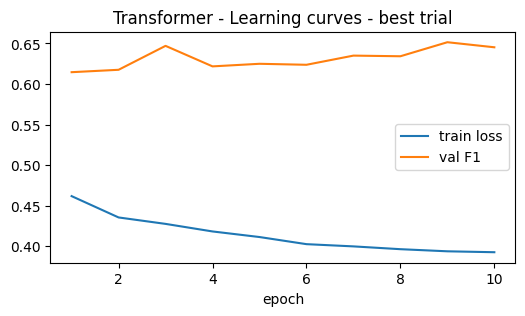

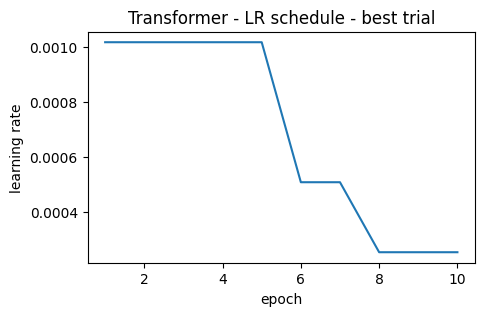

In [12]:
best = study.best_trial
epochs = range(1, len(best.user_attrs["lr_curve"]) + 1)

plt.figure(figsize=(6, 3))
plt.plot(epochs, best.user_attrs["train_loss_curve"], label="train loss")
plt.plot(epochs, best.user_attrs["val_f1_curve"], label="val F1")
plt.xlabel("epoch")
plt.legend()
plt.title("Transformer - Learning curves - best trial")
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(epochs, best.user_attrs["lr_curve"])
plt.xlabel("epoch")
plt.ylabel("learning rate")
plt.title("Transformer - LR schedule - best trial")
plt.show()

Confusion matrix (rows: true, cols: pred)
[[10856  2540]
 [ 2290  4129]] 

Accuracy     : 0.756
Recall (TPR) : 0.643
Specificity  : 0.810
Precision    : 0.619
F1-score     : 0.631


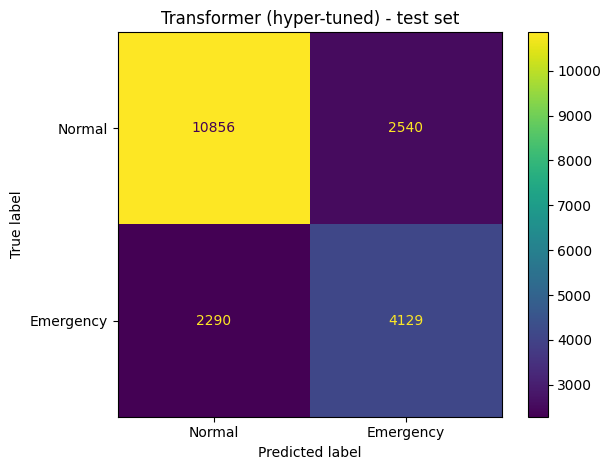

In [13]:
model = TransformerClassifier(
    n_feats=X_te.shape[2],
    d_model=best.params["d_model"],
    n_head=best.params["n_head"],
    n_layers=best.params["n_layers"],
    dim_ff=best.params["dim_ff"],
    dropout=best.params["drop"],
).to(DEVICE)
model.load_state_dict(torch.load(best.user_attrs["ckpt"], map_location=DEVICE))
model.eval()

preds, gts = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logit = model(xb.to(DEVICE))
        preds.extend((torch.sigmoid(logit) > 0.5).cpu().numpy().ravel())
        gts.extend(yb.numpy().ravel())
y_pred, y_true = np.array(preds, int), np.array(gts, int)

cm = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = cm.ravel()
acc = accuracy_score(y_true, y_pred)
recall = TP / (TP + FN + 1e-12)
spec = TN / (TN + FP + 1e-12)
prec = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Confusion matrix (rows: true, cols: pred)")
print(cm, "\n")
print(f"Accuracy     : {acc :.3f}")
print(f"Recall (TPR) : {recall :.3f}")
print(f"Specificity  : {spec :.3f}")
print(f"Precision    : {prec :.3f}")
print(f"F1-score     : {f1 :.3f}")

fig, ax = plt.subplots()
ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Normal", "Emergency"]
).plot(ax=ax)
ax.set_title("Transformer (hyper-tuned) - test set")
plt.tight_layout()
plt.show()

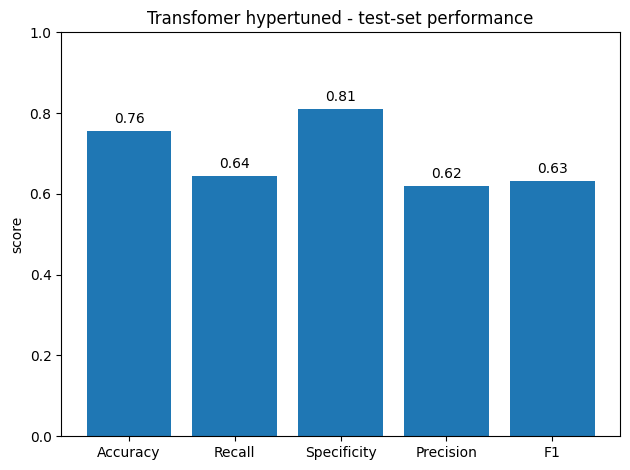

In [14]:
fig2, ax2 = plt.subplots()
metrics = [acc, recall, spec, prec, f1]
labels = ["Accuracy", "Recall", "Specificity", "Precision", "F1"]
ax2.bar(labels, metrics)
ax2.set_ylim(0, 1)
ax2.set_ylabel("score")
ax2.set_title("Transfomer hypertuned - test-set performance")
for idx, v in enumerate(metrics):  # annotate bars
    ax2.text(idx, v + 0.02, f"{v:.2f}", ha="center")
plt.tight_layout()
plt.show()